####################################################
# American Express Default Prediction
####################################################

### Objective


American Express is a globally integrated payments company. The largest payment card issuer in the world, they provide customers with access to products, insights, and experiences that enrich lives and build business success.

The objective is to predict the probability that a customer does not pay back their credit card balance amount in the future based on their monthly customer profile. 

In this project, I'll apply machine learning to predict credit default. 

### Data Overview

The target binary variable is calculated by observing 18 months performance window after the latest credit card statement, 
and if the customer does not pay due amount in 120 days after their latest statement date it is considered a default event.

The dataset contains aggregated profile features for each customer at each statement date. 
Features are anonymized and normalized, and fall into the following general categories:
D_*: Delinquency variables
S_*: Spend variables
P_*: Payment variables
B_*: Balance variables
R_*: Risk variables
With the following features being categorical: B_30, B_38, D_63, D_64, D_66, D_68, D_114, D_116, D_117, D_120, D_126.

There are a total of 190 variables in the dataset with approximately 450,000 customers in the training set and 
925,000 in the test set. 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [3]:
train_data =  pd.read_feather('train.ftr')
print(train_data.head())
#test_data = pd.read_feather('test.ftr')
#print(test_data.head())


                                         customer_ID        S_2       P_2  \
0  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f... 2017-03-09  0.938477   
1  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f... 2017-04-07  0.936523   
2  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f... 2017-05-28  0.954102   
3  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f... 2017-06-13  0.960449   
4  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f... 2017-07-16  0.947266   

       D_39       B_1       B_2       R_1       S_3      D_41       B_3  ...  \
0  0.001734  0.008728  1.006836  0.009224  0.124023  0.008774  0.004707  ...   
1  0.005775  0.004925  1.000977  0.006153  0.126709  0.000798  0.002714  ...   
2  0.091492  0.021652  1.009766  0.006817  0.123962  0.007599  0.009422  ...   
3  0.002455  0.013687  1.002930  0.001372  0.117188  0.000685  0.005531  ...   
4  0.002483  0.015190  1.000977  0.007607  0.117310  0.004654  0.009308  ...   

   D_137  D_138     D_139     D_140     D_141  D_142    

In [4]:
# Creating column mappings
spend_columns = {"S_" + str(i).split('_')[1]: "Spend_" + str(i).split('_')[1] for i in train_data.columns if i.startswith('S')}
delinquency_columns = {"D_" + str(i).split('_')[1]: "Delinquency_" + str(i).split('_')[1] for i in train_data.columns if i.startswith('D')}
payment_columns = {"P_" + str(i).split('_')[1]: "Payment_" + str(i).split('_')[1] for i in train_data.columns if i.startswith('P')}
balance_columns = {"B_" + str(i).split('_')[1]: "Balance_" + str(i).split('_')[1] for i in train_data.columns if i.startswith('B')}
risk_columns = {"R_" + str(i).split('_')[1]: "Risk_" + str(i).split('_')[1] for i in train_data.columns if i.startswith('R')}

# Merging mappings
column_mapping = {**spend_columns, **delinquency_columns, **payment_columns, **balance_columns, **risk_columns}

# Renaming column names
train_data.rename(columns=column_mapping, inplace=True)
#test_data.rename(columns=column_mapping, inplace=True)

In [13]:
print(train_data.columns)
len(train_data.columns)
#print(test_data.columns)
#len(test_data.columns)
df = train_data.copy()

Index(['customer_ID', 'Spend_2', 'Payment_2', 'Delinquency_39', 'Balance_1',
       'Balance_2', 'Risk_1', 'Spend_3', 'Delinquency_41', 'Balance_3',
       ...
       'Delinquency_137', 'Delinquency_138', 'Delinquency_139',
       'Delinquency_140', 'Delinquency_141', 'Delinquency_142',
       'Delinquency_143', 'Delinquency_144', 'Delinquency_145', 'target'],
      dtype='object', length=191)


In [8]:
# del test_data
#test_data.to_feather('test.ftr')

In [7]:
categorical_columns = ["Balance_30", "Balance_38", "Delinquency_63", "Delinquency_64", "Delinquency_66", "Delinquency_68",
                       "Delinquency_114", "Delinquency_116", "Delinquency_117", "Delinquency_120", "Delinquency_126"]

numerical_columns = [i for i in train_data.columns if i not in categorical_columns and not i.startswith('target') and train_data[i].dtype == 'float16']

In [8]:
print(train_data.shape[1])
print(len(categorical_columns))
print(len(numerical_columns))

191
11
176


### Exploratory Data Analysis


##### Target Value Distribution

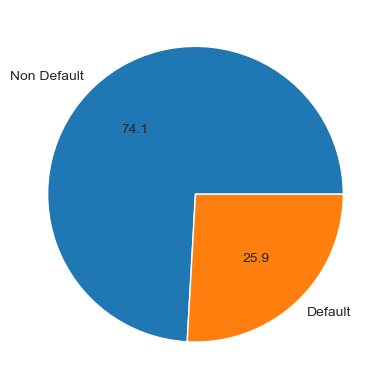

In [9]:
default = train_data['target'].value_counts(normalize=True).reset_index()
plt.pie(default['proportion'], labels=['Non Default', 'Default'], normalize= True, autopct='%1.1f')
plt.show()

##### Time related variable

In [14]:
df.Spend_2.min(), train_data.Spend_2.max()

(Timestamp('2017-03-01 00:00:00'), Timestamp('2018-03-31 00:00:00'))

##### Missing Value Analysis

In [77]:
df.isnull().sum()

customer_ID                    0
Spend_2                        0
Payment_2                  45985
Delinquency_39                 0
Balance_1                      0
                           ...  
Delinquency_142_missing        0
Delinquency_143_missing        0
Delinquency_144_missing        0
Delinquency_145_missing        0
target_missing                 0
Length: 314, dtype: int64

In [16]:
missing_columns = [i for i in df if df[i].isnull().sum()>0]

In [17]:
from scipy.stats import chi2_contingency
# Chi2 is  hypothesis test of independence of the observed frequencies in the contingency table [1]_ `observed`
chi2_significant_columns = []
for column in missing_columns:
    df[f'{column}_missing'] = df[column].isnull().astype(int)
    contingency_table = pd.crosstab(df[f'{column}_missing'], df["target"])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    print(f'Chi-Square Test for {column}: chi2 - {chi2:.4f} -- p_value - {p_value:.4f}')
    
    if p_value < 0.05:
        chi2_significant_columns.append(column)
print("Significant columns with p-value < 0.05:", chi2_significant_columns)    


Chi-Square Test for Payment_2: chi2 - 0.5980 -- p_value - 0.4394
Chi-Square Test for Balance_2: chi2 - 6.6578 -- p_value - 0.0099
Chi-Square Test for Spend_3: chi2 - 0.0311 -- p_value - 0.8599
Chi-Square Test for Delinquency_41: chi2 - 6.6578 -- p_value - 0.0099
Chi-Square Test for Balance_3: chi2 - 6.6578 -- p_value - 0.0099
Chi-Square Test for Delinquency_42: chi2 - 2.3827 -- p_value - 0.1227
Chi-Square Test for Delinquency_43: chi2 - 1.2792 -- p_value - 0.2580
Chi-Square Test for Delinquency_44: chi2 - 0.0035 -- p_value - 0.9529
Chi-Square Test for Delinquency_45: chi2 - 6.6578 -- p_value - 0.0099
Chi-Square Test for Delinquency_46: chi2 - 0.9878 -- p_value - 0.3203
Chi-Square Test for Delinquency_48: chi2 - 0.0061 -- p_value - 0.9375
Chi-Square Test for Delinquency_49: chi2 - 1.0515 -- p_value - 0.3052
Chi-Square Test for Balance_6: chi2 - 0.0512 -- p_value - 0.8209
Chi-Square Test for Balance_8: chi2 - 1.7847 -- p_value - 0.1816
Chi-Square Test for Delinquency_50: chi2 - 2.2549 --

In [18]:
len(chi2_significant_columns)

21

###### Interpretation of Chi-Square Impact:
1. Statistical Independence:

* The Chi-Square test assesses whether there is a significant association between categorical variables—in this case, 
    missing values and the target variable (e.g., default status).

* A low p-value (typically < 0.05) indicates that the null hypothesis of independence can be rejected, 
    suggesting a significant relationship exists. This implies that the missing values are not randomly distributed 
    and are related to the target outcome.

2. Feature Engineering:

* The findings can inform feature engineering strategies. For instance, creating new features based on missingness 
 (e.g., binary indicators for missing values) can capture relevant information that may help improve model performance

In [19]:
df.groupby('customer_ID').agg({'Payment_2': 'count'}).sort_values(by= 'Payment_2', ascending=False)


,Payment_2
customer_ID,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,13
a278a5f79af6b646f08ab559adae47242e205ef3a850339da24d2afb73010702,13
a279fd0363aafebf5e64cbaf0c6ec64dad7834318b7915afaba8e2ad62cb333f,13
a279ef01e9cc647c6e3dc32604add6464b81a4e09917361f3e3d8f076e99a1dd,13
a279e989e136ad074d052fe214124e3718830ba15c8d06885805f258e333a3e9,13
...,...
04d291b888eb0620564719214e70fd83bc06b12f0cd1b13596c8cd0db2fb943f,0
5e5d6905ecd429bcb4e34dbea84e080e3a0588abde0a40543f8ea65ae6c55b58,0
65ebbdab2905c834a595b78c762790d596087980bd28be1ba8934cf69428204f,0


In [20]:
spend_columns = [i for i in train_data.columns if i.startswith('Spend')]
delinquency_columns = [i for i in train_data.columns if i.startswith('Delinquency')]
payment_columns = [i for i in train_data.columns if i.startswith('Payment')]
balance_columns = [i for i in train_data.columns if i.startswith('Balance')]
risk_columns = [i for i in train_data.columns if i.startswith('Risk')]

In [21]:
print(len(spend_columns))
print(len(delinquency_columns))
print(len(payment_columns))
print(len(balance_columns))
print(len(risk_columns))

22
96
3
40
28


##### Spend Columns

In [29]:
from scipy.stats import shapiro

spend_normal_distribution = []
spend_nonnormal_distribution = []
for i in spend_columns[1:]: # First element is time series, exclude.
    stat, p_value = shapiro(df[i])
    if p_value > 0.05:
        print(f' {i} has normal distribution: Shapiro test: {p_value: .4f}' )
        spend_normal_distribution.append(i)
    else:
        print(f' {i} has not normal distribution: Shapiro test: {p_value: .4f}')
        spend_nonnormal_distribution.append(i)


 Spend_3 has normal distribution: Shapiro test:  1.0000
 Spend_5 has not normal distribution: Shapiro test:  0.0000
 Spend_6 has not normal distribution: Shapiro test:  0.0000
 Spend_7 has normal distribution: Shapiro test:  1.0000
 Spend_8 has not normal distribution: Shapiro test:  0.0000
 Spend_9 has normal distribution: Shapiro test:  1.0000
 Spend_11 has not normal distribution: Shapiro test:  0.0000
 Spend_12 has not normal distribution: Shapiro test:  0.0000
 Spend_13 has not normal distribution: Shapiro test:  0.0000
 Spend_15 has not normal distribution: Shapiro test:  0.0000
 Spend_16 has not normal distribution: Shapiro test:  0.0000
 Spend_17 has not normal distribution: Shapiro test:  0.0000
 Spend_18 has not normal distribution: Shapiro test:  0.0000
 Spend_19 has not normal distribution: Shapiro test:  0.0000
 Spend_20 has not normal distribution: Shapiro test:  0.0000
 Spend_22 has normal distribution: Shapiro test:  1.0000
 Spend_23 has normal distribution: Shapiro tes

In [30]:
print(spend_normal_distribution)
print(spend_nonnormal_distribution)

['Spend_3', 'Spend_7', 'Spend_9', 'Spend_22', 'Spend_23', 'Spend_24', 'Spend_25', 'Spend_26', 'Spend_27']
['Spend_5', 'Spend_6', 'Spend_8', 'Spend_11', 'Spend_12', 'Spend_13', 'Spend_15', 'Spend_16', 'Spend_17', 'Spend_18', 'Spend_19', 'Spend_20']


In [34]:
from scipy.stats import ttest_ind

spend_t_testsignificant_column = []
spend_t_testnonsignificant_column = []

for i in spend_normal_distribution:
    group_1 = df[df.target == 0][i].dropna()
    group_2 = df[df.target == 1][i].dropna()

    # Sabit veriler kontrolü
    if group_1.nunique() == 1 or group_2.nunique() == 1:
        print(f'{i} has constant values in one of the groups, skipping T-test')
        continue

    stat, p_value = ttest_ind(group_1, group_2)

    if p_value > 0.05:
        spend_t_testnonsignificant_column.append(i)
        print(f'{i} has no significant effect: T-test p-value: {p_value:.4f}')
    else:
        spend_t_testsignificant_column.append(i)
        print(f'{i} has significant effect: T-test p-value: {p_value:.4f}')


Spend_3 has no significant effect: T-test p-value: 0.5015
Spend_7 has no significant effect: T-test p-value: 0.8743
Spend_9 has no significant effect: T-test p-value: 0.7528
Spend_22 has no significant effect: T-test p-value: 1.0000
Spend_23 has no significant effect: T-test p-value: 1.0000
Spend_24 has no significant effect: T-test p-value: 0.8763
Spend_25 has no significant effect: T-test p-value: 0.1650
Spend_26 has no significant effect: T-test p-value: 0.0737
Spend_27 has no significant effect: T-test p-value: 1.0000


* Normal distributed spend columns has no effect on target

In [37]:
from scipy.stats import mannwhitneyu

spend_significant_column = []
spend_nonsignificant_column = []

for i in spend_nonnormal_distribution:
    group_1 = df[df.target == 0][i].dropna()
    group_2 = df[df.target == 1][i].dropna()

    # Sabit veriler kontrolü
    if group_1.nunique() == 1 or group_2.nunique() == 1:
        print(f'{i} has constant values in one of the groups, skipping test')
        continue

    stat, p_value = mannwhitneyu(group_1, group_2)

    if p_value > 0.05:
        spend_nonsignificant_column.append(i)
        print(f'{i} has no significant effect: MannwhitneyU test p-value: {p_value:.4f}')
    else:
        spend_significant_column.append(i)
        print(f'{i} has significant effect: MannwhitneyU test p-value: {p_value:.4f}')

Spend_5 has no significant effect: MannwhitneyU test p-value: 0.4573
Spend_6 has no significant effect: MannwhitneyU test p-value: 0.0942
Spend_8 has no significant effect: MannwhitneyU test p-value: 0.9448
Spend_11 has no significant effect: MannwhitneyU test p-value: 0.3871
Spend_12 has no significant effect: MannwhitneyU test p-value: 0.7540
Spend_13 has no significant effect: MannwhitneyU test p-value: 0.2958
Spend_15 has no significant effect: MannwhitneyU test p-value: 0.8276
Spend_16 has no significant effect: MannwhitneyU test p-value: 0.5938
Spend_17 has significant effect: MannwhitneyU test p-value: 0.0359
Spend_18 has no significant effect: MannwhitneyU test p-value: 0.9796
Spend_19 has no significant effect: MannwhitneyU test p-value: 0.7062
Spend_20 has no significant effect: MannwhitneyU test p-value: 0.5213


* Spend_17 has significant effect on target variable

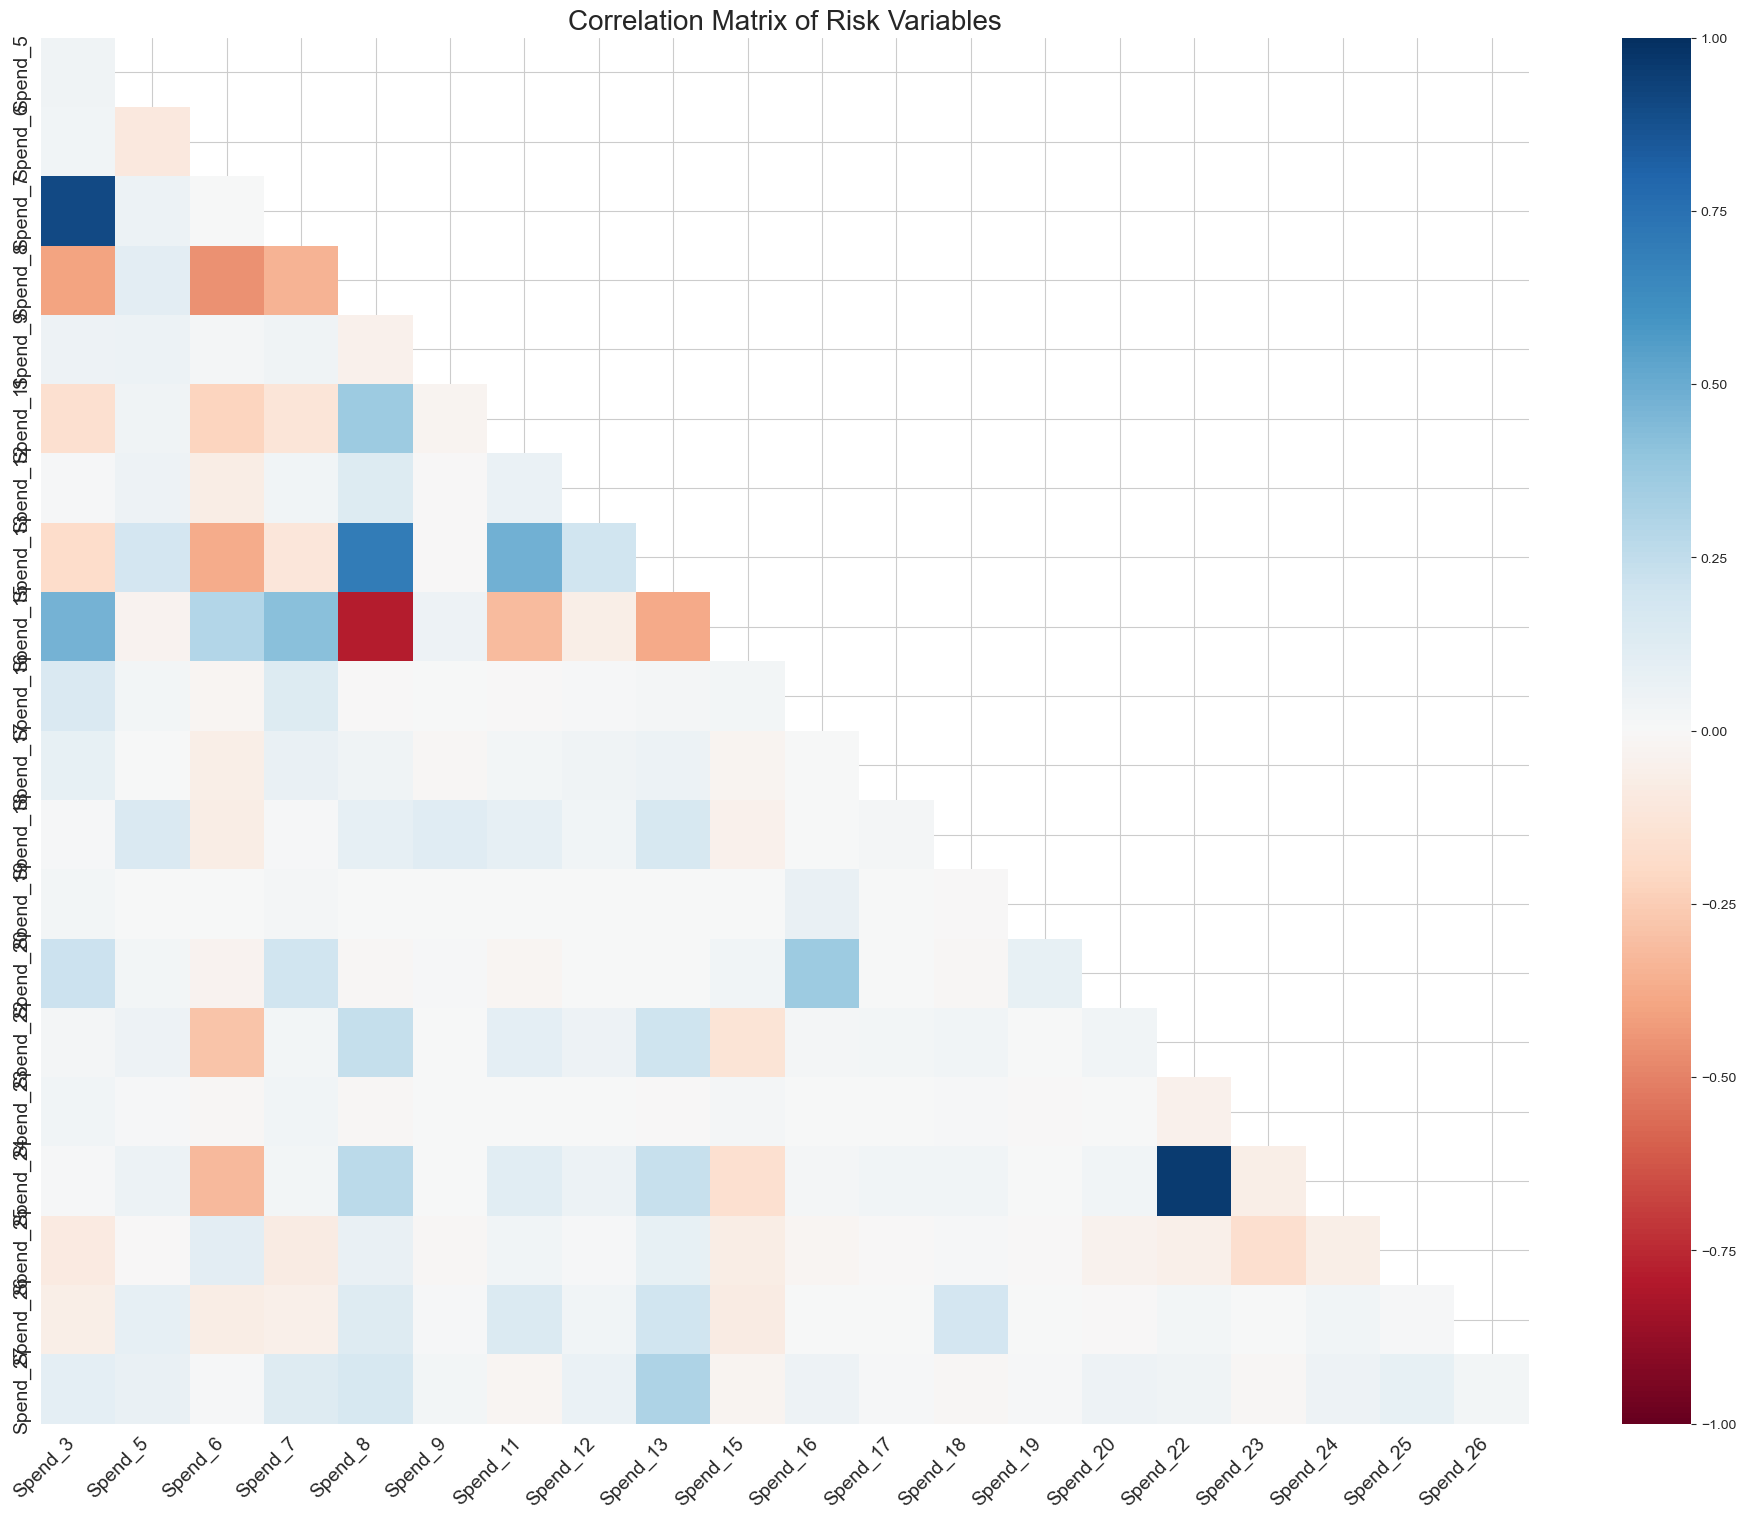

In [74]:
# Correlation
corr = df[spend_columns[1:]].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))[1:, :-1]
corr = corr.iloc[1:, :-1].copy()

fig, ax = plt.subplots(figsize=(24, 18))
sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, center=0, annot=False, 
            cmap='RdBu', cbar=True, linecolor='white', linewidths=0)

ax.tick_params(left=False, bottom=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
plt.title('Correlation Matrix of Spend Variables', fontsize=20)
plt.show()

##### Delinquency Columns

In [40]:
delinquency_normal_distribution = []
delinquency_nonnormal_distribution = []
for i in delinquency_columns: # First element is time series, exclude.
    if i in numerical_columns:
        stat, p_value = shapiro(df[i])
        if p_value > 0.05:
            print(f' {i} has normal distribution: Shapiro test: {p_value: .4f}' )
            delinquency_normal_distribution.append(i)
        else:
            print(f' {i} has not normal distribution: Shapiro test: {p_value: .4f}')
            delinquency_nonnormal_distribution.append(i)

 Delinquency_39 has not normal distribution: Shapiro test:  0.0000
 Delinquency_41 has normal distribution: Shapiro test:  1.0000
 Delinquency_42 has normal distribution: Shapiro test:  1.0000
 Delinquency_43 has normal distribution: Shapiro test:  1.0000
 Delinquency_44 has normal distribution: Shapiro test:  1.0000
 Delinquency_45 has normal distribution: Shapiro test:  1.0000
 Delinquency_46 has normal distribution: Shapiro test:  1.0000
 Delinquency_47 has not normal distribution: Shapiro test:  0.0000
 Delinquency_48 has normal distribution: Shapiro test:  1.0000
 Delinquency_49 has normal distribution: Shapiro test:  1.0000
 Delinquency_50 has normal distribution: Shapiro test:  1.0000
 Delinquency_51 has not normal distribution: Shapiro test:  0.0000
 Delinquency_52 has normal distribution: Shapiro test:  1.0000
 Delinquency_53 has normal distribution: Shapiro test:  1.0000
 Delinquency_54 has normal distribution: Shapiro test:  1.0000
 Delinquency_55 has normal distribution: Sh

In [41]:
from scipy.stats import ttest_ind

delinquency_t_testsignificant_column = []
delinquency_t_testnonsignificant_column = []

for i in delinquency_normal_distribution:
    group_1 = df[df.target == 0][i].dropna()
    group_2 = df[df.target == 1][i].dropna()

    # Sabit veriler kontrolü
    if group_1.nunique() == 1 or group_2.nunique() == 1:
        print(f'{i} has constant values in one of the groups, skipping T-test')
        continue

    stat, p_value = ttest_ind(group_1, group_2)

    if p_value > 0.05:
        delinquency_t_testnonsignificant_column.append(i)
        print(f'{i} has no significant effect: T-test p-value: {p_value:.4f}')
    else:
        delinquency_t_testsignificant_column.append(i)
        print(f'{i} has significant effect: T-test p-value: {p_value:.4f}')

Delinquency_41 has no significant effect: T-test p-value: 0.3964
Delinquency_42 has no significant effect: T-test p-value: 0.1825
Delinquency_43 has no significant effect: T-test p-value: 0.7792
Delinquency_44 has no significant effect: T-test p-value: 0.8107
Delinquency_45 has no significant effect: T-test p-value: 0.1345
Delinquency_46 has no significant effect: T-test p-value: 0.4465
Delinquency_48 has no significant effect: T-test p-value: 0.2155
Delinquency_49 has no significant effect: T-test p-value: 0.1815
Delinquency_50 has no significant effect: T-test p-value: 0.6262
Delinquency_52 has no significant effect: T-test p-value: 0.6782
Delinquency_53 has no significant effect: T-test p-value: 0.2334
Delinquency_54 has no significant effect: T-test p-value: 0.3080
Delinquency_55 has no significant effect: T-test p-value: 0.4613
Delinquency_56 has no significant effect: T-test p-value: 0.2351
Delinquency_59 has no significant effect: T-test p-value: 0.7096
Delinquency_61 has no sig

* 'Delinquency_108', 'Delinquency_113', 'Delinquency_128' columns have significant effect on target column

In [43]:
from scipy.stats import mannwhitneyu

delinquency_mwu_test_significant_column = []
delinquency_mwu_test_nonsignificant_column = []

for i in delinquency_nonnormal_distribution:
    if i in numerical_columns:
        group_1 = df[df.target == 0][i].dropna()
        group_2 = df[df.target == 1][i].dropna()

    # Sabit veriler kontrolü
        if group_1.nunique() == 1 or group_2.nunique() == 1:
            print(f'{i} has constant values in one of the groups, skipping test')
            continue

        stat, p_value = mannwhitneyu(group_1, group_2)

        if p_value > 0.05:
            delinquency_mwu_test_nonsignificant_column.append(i)
            print(f'{i} has no significant effect: MannwhitneyU test p-value: {p_value:.4f}')
        else:
            delinquency_mwu_test_significant_column.append(i)
            print(f'{i} has significant effect: MannwhitneyU test p-value: {p_value:.4f}')

Delinquency_39 has no significant effect: MannwhitneyU test p-value: 0.9903
Delinquency_47 has no significant effect: MannwhitneyU test p-value: 0.2321
Delinquency_51 has no significant effect: MannwhitneyU test p-value: 0.4659
Delinquency_58 has no significant effect: MannwhitneyU test p-value: 0.6601
Delinquency_60 has no significant effect: MannwhitneyU test p-value: 0.4031
Delinquency_65 has no significant effect: MannwhitneyU test p-value: 0.5363
Delinquency_71 has no significant effect: MannwhitneyU test p-value: 0.1339
Delinquency_75 has no significant effect: MannwhitneyU test p-value: 0.1233
Delinquency_86 has no significant effect: MannwhitneyU test p-value: 0.5865
Delinquency_92 has no significant effect: MannwhitneyU test p-value: 0.8428
Delinquency_93 has significant effect: MannwhitneyU test p-value: 0.0139
Delinquency_94 has no significant effect: MannwhitneyU test p-value: 0.8169
Delinquency_96 has no significant effect: MannwhitneyU test p-value: 0.7249
Delinquency_127

In [44]:
print(delinquency_mwu_test_significant_column)

['Delinquency_93']


* Delinquency_93 has significant effect on target

In [47]:
from scipy.stats import chi2_contingency
deliquency_chi2_test_nonsignificant_column = []
deliquency_chi2_test_significant_column = []

for i in delinquency_columns:
    if i in categorical_columns:
        contingency_table =  pd.crosstab(df[i], df['target'])
        chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
        if p_value > 0.05:
            deliquency_chi2_test_nonsignificant_column.append(i)
            print(f'{i} has no significant effect. Chi2 test - p-value: {p_value:.4f}')
        else:
            deliquency_chi2_test_significant_column.append(i)
            print(f'{i} has a significant effect. Chi2 test - p-value: {p_value:.4f}')
            

Delinquency_63 has no significant effect. Chi2 test - p-value: 0.0939
Delinquency_64 has no significant effect. Chi2 test - p-value: 0.6424
Delinquency_66 has no significant effect. Chi2 test - p-value: 0.3583
Delinquency_68 has no significant effect. Chi2 test - p-value: 0.1769
Delinquency_114 has no significant effect. Chi2 test - p-value: 0.4841
Delinquency_116 has no significant effect. Chi2 test - p-value: 0.7876
Delinquency_117 has no significant effect. Chi2 test - p-value: 0.7394
Delinquency_120 has no significant effect. Chi2 test - p-value: 0.2473
Delinquency_126 has no significant effect. Chi2 test - p-value: 0.8739


* Categorical delinquency columns have no significant effect on target

##### Payment Columns

In [48]:
payment_normal_distribution = []
payment_nonnormal_distribution = []
for i in payment_columns:  # First element is time series, exclude.
    if i in numerical_columns:
        stat, p_value = shapiro(df[i])
        if p_value > 0.05:
            print(f' {i} has normal distribution: Shapiro test: {p_value: .4f}')
            payment_normal_distribution.append(i)
        else:
            print(f' {i} has not normal distribution: Shapiro test: {p_value: .4f}')
            payment_nonnormal_distribution.append(i)


 Payment_2 has normal distribution: Shapiro test:  1.0000
 Payment_3 has normal distribution: Shapiro test:  1.0000
 Payment_4 has not normal distribution: Shapiro test:  0.0000


In [49]:
from scipy.stats import ttest_ind
payment_t_testsignificant_column = []
payment_t_testnonsignificant_column = []

for i in payment_normal_distribution:
    group_1 = df[df.target == 0][i].dropna()
    group_2 = df[df.target == 1][i].dropna()

    # Sabit veriler kontrolü
    if group_1.nunique() == 1 or group_2.nunique() == 1:
        print(f'{i} has constant values in one of the groups, skipping T-test')
        continue

    stat, p_value = ttest_ind(group_1, group_2)

    if p_value > 0.05:
        payment_t_testnonsignificant_column.append(i)
        print(f'{i} has no significant effect: T-test p-value: {p_value:.4f}')
    else:
        payment_t_testsignificant_column.append(i)
        print(f'{i} has significant effect: T-test p-value: {p_value:.4f}')


Payment_2 has no significant effect: T-test p-value: 1.0000
Payment_3 has no significant effect: T-test p-value: 0.4057


In [50]:
from scipy.stats import mannwhitneyu

payment_mwu_test_significant_column = []
payment_mwu_test_nonsignificant_column = []

for i in payment_nonnormal_distribution:
    if i in numerical_columns:
        group_1 = df[df.target == 0][i].dropna()
        group_2 = df[df.target == 1][i].dropna()

        # Sabit veriler kontrolü
        if group_1.nunique() == 1 or group_2.nunique() == 1:
            print(f'{i} has constant values in one of the groups, skipping test')
            continue

        stat, p_value = mannwhitneyu(group_1, group_2)

        if p_value > 0.05:
            delinquency_mwu_test_nonsignificant_column.append(i)
            print(f'{i} has no significant effect: MannwhitneyU test p-value: {p_value:.4f}')
        else:
            delinquency_mwu_test_significant_column.append(i)
            print(f'{i} has significant effect: MannwhitneyU test p-value: {p_value:.4f}')

Payment_4 has significant effect: MannwhitneyU test p-value: 0.0108


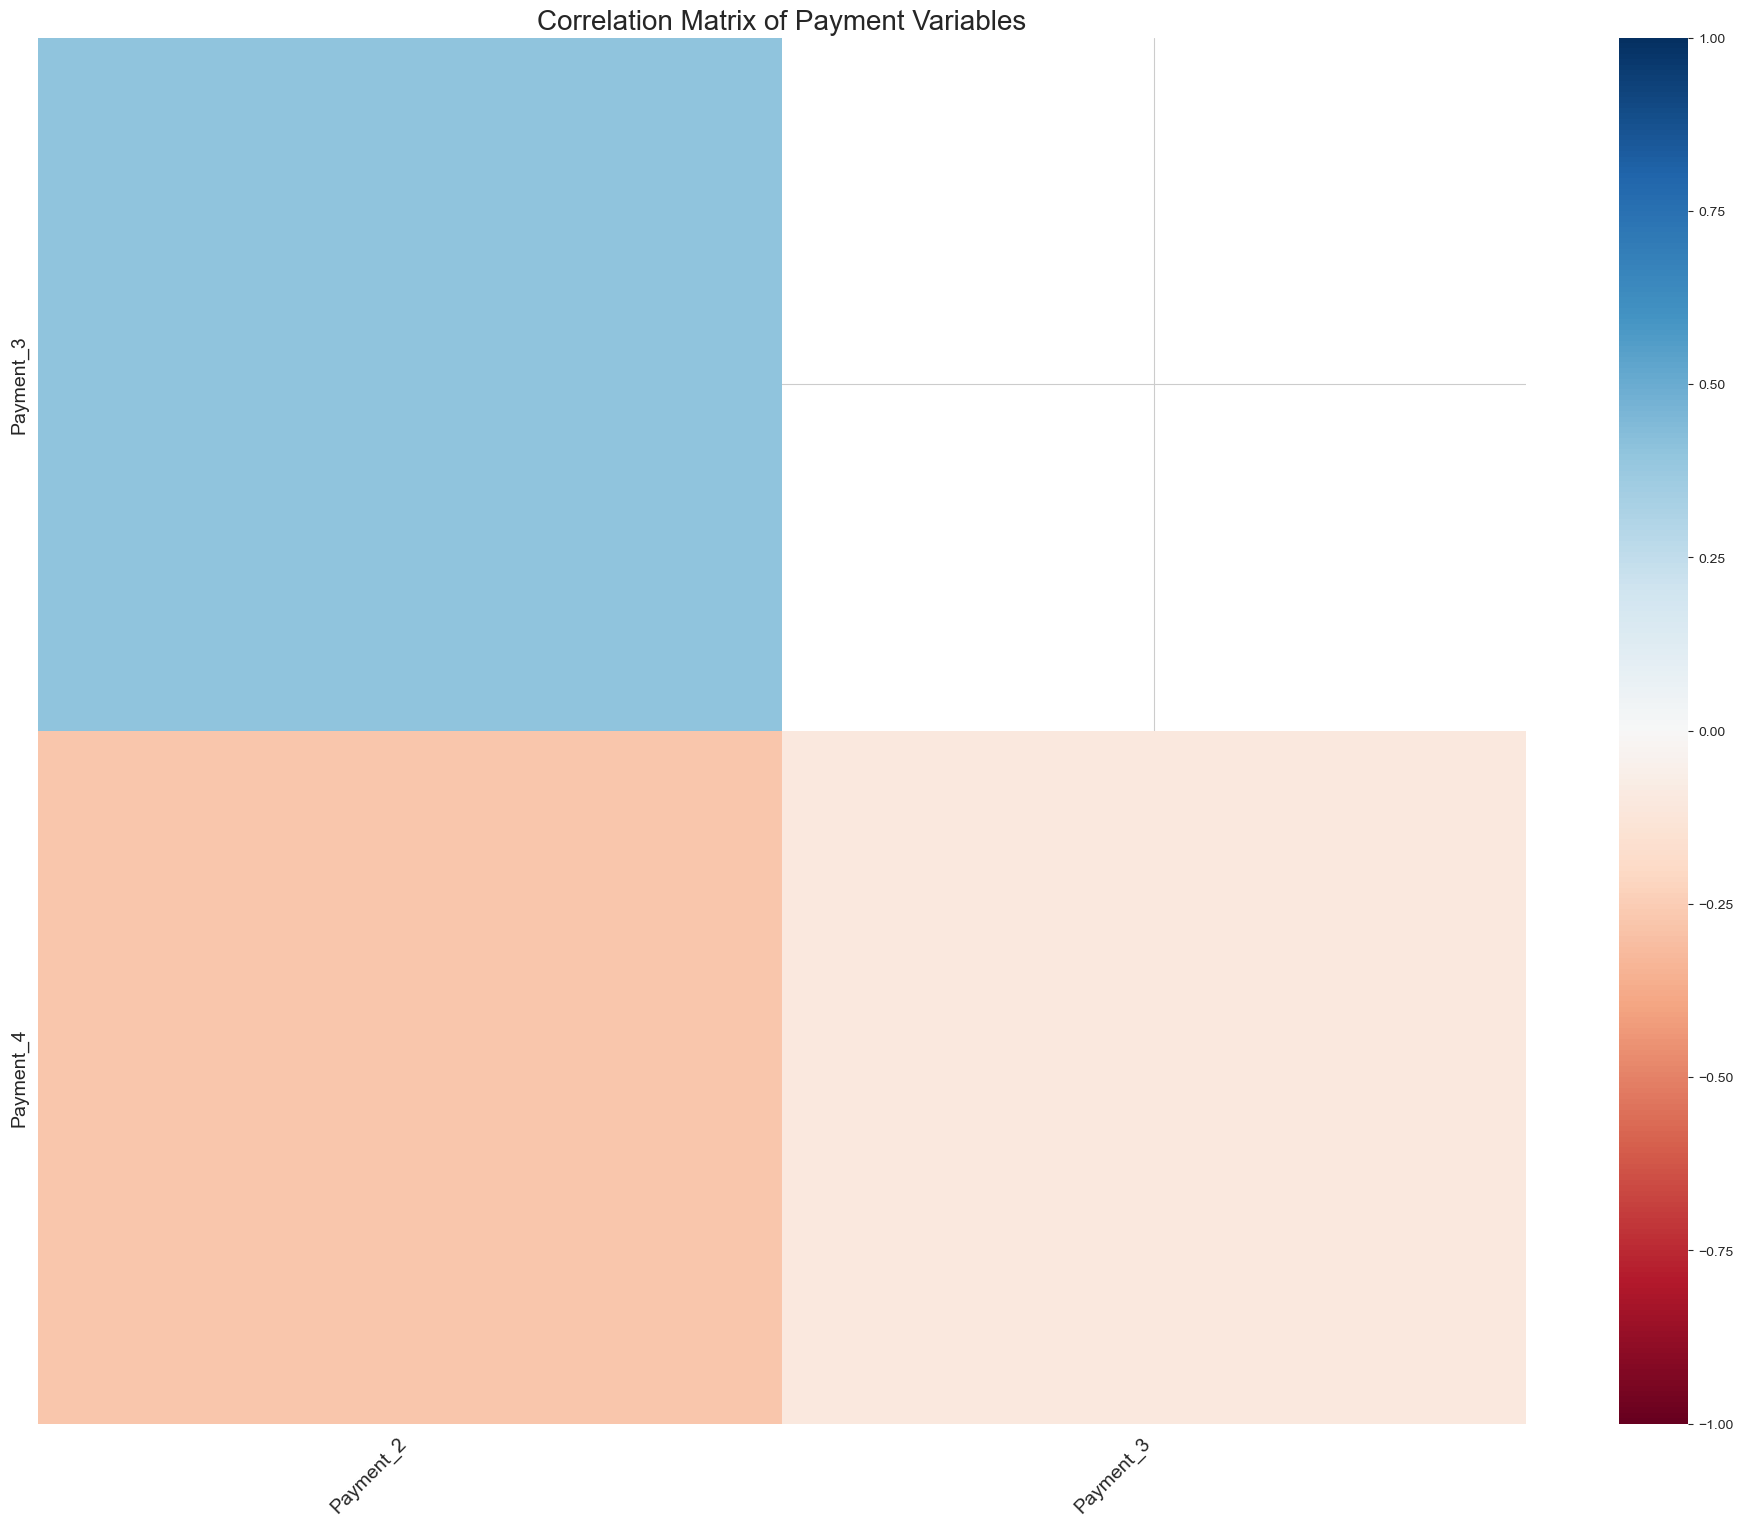

In [75]:
# Correlation
corr = df[payment_columns].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))[1:, :-1]
corr = corr.iloc[1:, :-1].copy()

fig, ax = plt.subplots(figsize=(24, 18))
sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, center=0, annot=False, 
            cmap='RdBu', cbar=True, linecolor='white', linewidths=0)

ax.tick_params(left=False, bottom=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
plt.title('Correlation Matrix of Payment Variables', fontsize=20)
plt.show()

* Payment 4 has significant effect on target

##### Balance columns 


In [53]:
balance_normal_distribution = []
balance_nonnormal_distribution = []
for i in balance_columns:  # First element is time series, exclude.
    if i in numerical_columns:
        stat, p_value = shapiro(df[i])
        if p_value > 0.05:
            print(f' {i} has normal distribution: Shapiro test: {p_value: .4f}')
            balance_normal_distribution.append(i)
        else:
            print(f' {i} has not normal distribution: Shapiro test: {p_value: .4f}')
            balance_nonnormal_distribution.append(i)


 Balance_1 has not normal distribution: Shapiro test:  0.0000
 Balance_2 has normal distribution: Shapiro test:  1.0000
 Balance_3 has normal distribution: Shapiro test:  1.0000
 Balance_4 has not normal distribution: Shapiro test:  0.0000
 Balance_5 has not normal distribution: Shapiro test:  0.0000
 Balance_6 has normal distribution: Shapiro test:  1.0000
 Balance_7 has not normal distribution: Shapiro test:  0.0000
 Balance_8 has normal distribution: Shapiro test:  1.0000
 Balance_9 has not normal distribution: Shapiro test:  0.0000
 Balance_10 has not normal distribution: Shapiro test:  0.0000
 Balance_11 has not normal distribution: Shapiro test:  0.0000
 Balance_12 has not normal distribution: Shapiro test:  0.0000
 Balance_13 has normal distribution: Shapiro test:  1.0000
 Balance_14 has not normal distribution: Shapiro test:  0.0000
 Balance_15 has normal distribution: Shapiro test:  1.0000
 Balance_16 has normal distribution: Shapiro test:  1.0000
 Balance_17 has normal distri

In [54]:
from scipy.stats import ttest_ind
balance_t_testsignificant_column = []
balance_t_testnonsignificant_column = []

for i in balance_normal_distribution:
    group_1 = df[df.target == 0][i].dropna()
    group_2 = df[df.target == 1][i].dropna()

    # Sabit veriler kontrolü
    if group_1.nunique() == 1 or group_2.nunique() == 1:
        print(f'{i} has constant values in one of the groups, skipping T-test')
        continue

    stat, p_value = ttest_ind(group_1, group_2)

    if p_value > 0.05:
        balance_t_testnonsignificant_column.append(i)
        print(f'{i} has no significant effect: T-test p-value: {p_value:.4f}')
    else:
        balance_t_testsignificant_column.append(i)
        print(f'{i} has significant effect: T-test p-value: {p_value:.4f}')


Balance_2 has no significant effect: T-test p-value: 0.0714
Balance_3 has no significant effect: T-test p-value: 0.2194
Balance_6 has no significant effect: T-test p-value: 0.8490
Balance_8 has no significant effect: T-test p-value: 0.5607
Balance_13 has no significant effect: T-test p-value: 0.5642
Balance_15 has no significant effect: T-test p-value: 0.2336
Balance_16 has no significant effect: T-test p-value: 0.2078
Balance_17 has no significant effect: T-test p-value: 0.1376
Balance_19 has significant effect: T-test p-value: 0.0461
Balance_20 has no significant effect: T-test p-value: 0.5613
Balance_22 has no significant effect: T-test p-value: 0.1475
Balance_25 has no significant effect: T-test p-value: 0.1128
Balance_26 has no significant effect: T-test p-value: 1.0000
Balance_27 has no significant effect: T-test p-value: 0.4373
Balance_29 has no significant effect: T-test p-value: 0.1615
Balance_33 has no significant effect: T-test p-value: 0.1384
Balance_37 has no significant e

In [55]:
from scipy.stats import mannwhitneyu

balance_mwu_test_significant_column = []
balance_mwu_test_nonsignificant_column = []

for i in balance_nonnormal_distribution:
    if i in numerical_columns:
        group_1 = df[df.target == 0][i].dropna()
        group_2 = df[df.target == 1][i].dropna()

        # Sabit veriler kontrolü
        if group_1.nunique() == 1 or group_2.nunique() == 1:
            print(f'{i} has constant values in one of the groups, skipping test')
            continue

        stat, p_value = mannwhitneyu(group_1, group_2)

        if p_value > 0.05:
            balance_mwu_test_nonsignificant_column.append(i)
            print(f'{i} has no significant effect: MannwhitneyU test p-value: {p_value:.4f}')
        else:
            balance_mwu_test_significant_column.append(i)
            print(f'{i} has significant effect: MannwhitneyU test p-value: {p_value:.4f}')

Balance_1 has no significant effect: MannwhitneyU test p-value: 0.2791
Balance_4 has no significant effect: MannwhitneyU test p-value: 0.9699
Balance_5 has no significant effect: MannwhitneyU test p-value: 0.9700
Balance_7 has no significant effect: MannwhitneyU test p-value: 0.2547
Balance_9 has no significant effect: MannwhitneyU test p-value: 0.1252
Balance_10 has no significant effect: MannwhitneyU test p-value: 0.4326
Balance_11 has no significant effect: MannwhitneyU test p-value: 0.2389
Balance_12 has no significant effect: MannwhitneyU test p-value: 0.2178
Balance_14 has no significant effect: MannwhitneyU test p-value: 0.5235
Balance_18 has no significant effect: MannwhitneyU test p-value: 0.2899
Balance_21 has no significant effect: MannwhitneyU test p-value: 0.2933
Balance_23 has no significant effect: MannwhitneyU test p-value: 0.2352
Balance_24 has no significant effect: MannwhitneyU test p-value: 0.3624
Balance_28 has no significant effect: MannwhitneyU test p-value: 0.55

In [56]:
from scipy.stats import chi2_contingency
balance_chi2_test_nonsignificant_column = []
balance_chi2_test_significant_column = []

for i in balance_columns:
    if i in categorical_columns:
        contingency_table =  pd.crosstab(df[i], df['target'])
        chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
        if p_value > 0.05:
            balance_chi2_test_nonsignificant_column.append(i)
            print(f'{i} has no significant effect. Chi2 test - p-value: {p_value:.4f}')
        else:
            balance_chi2_test_significant_column.append(i)
            print(f'{i} has a significant effect. Chi2 test - p-value: {p_value:.4f}')
            

Balance_30 has no significant effect. Chi2 test - p-value: 0.0575
Balance_38 has no significant effect. Chi2 test - p-value: 0.1187


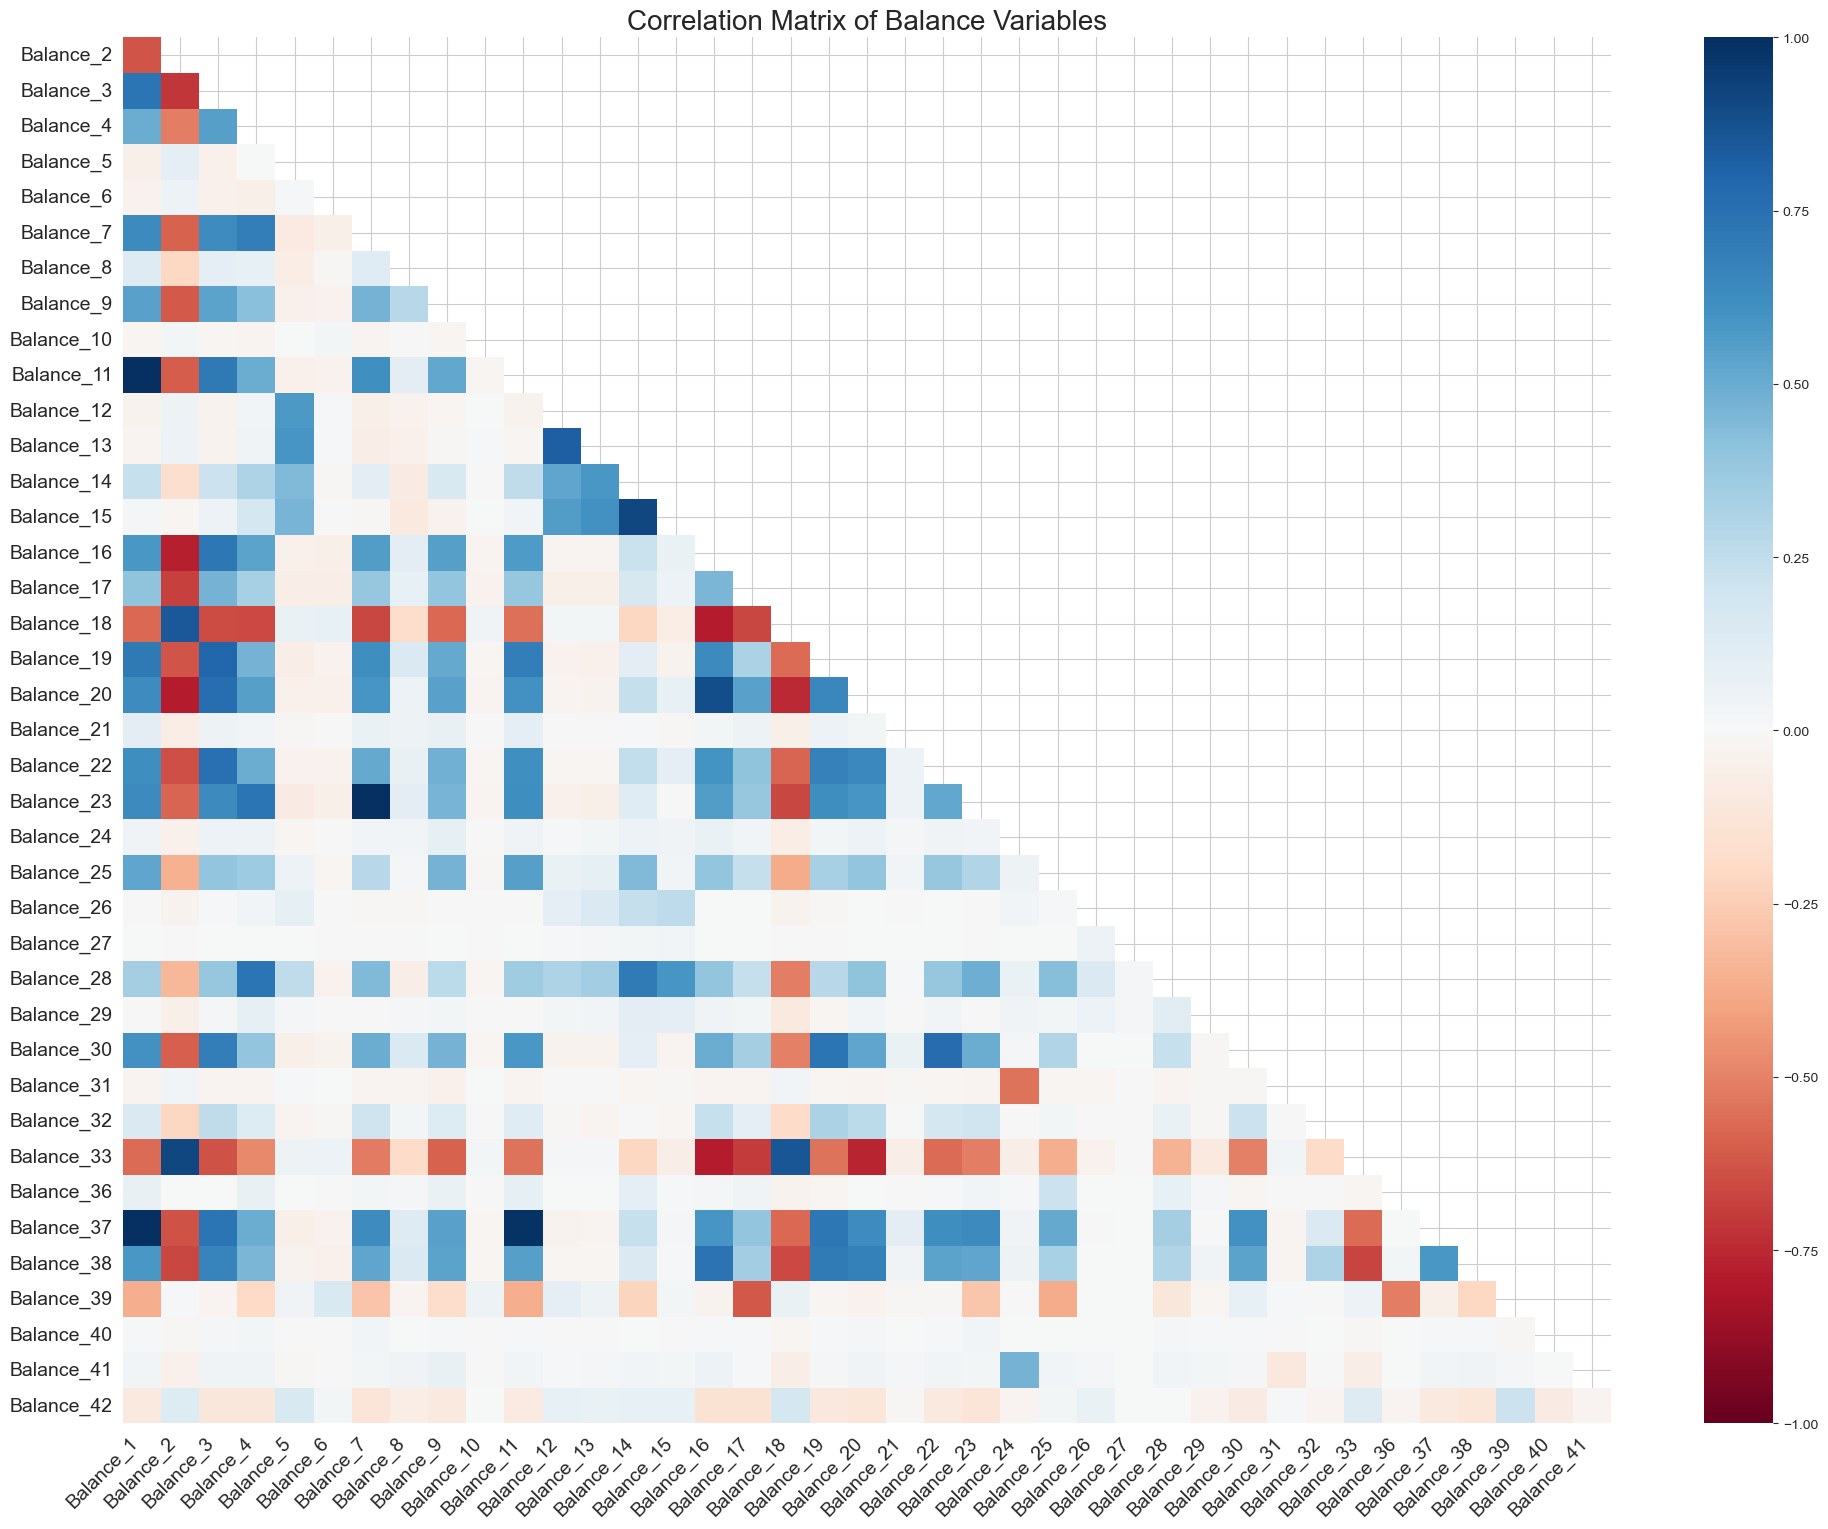

In [66]:
# Correlation
corr = df[balance_columns].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))[1:, :-1]
corr = corr.iloc[1:, :-1].copy()

fig, ax = plt.subplots(figsize=(24, 18))
sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, center=0, annot=False, 
            cmap='RdBu', cbar=True, linecolor="white", linewidths=0)

ax.tick_params(left=False, bottom=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
plt.title('Correlation Matrix of Balance Variables', fontsize=20)
plt.show()



##### Risk columns 

In [57]:
risk_normal_distribution = []
risk_nonnormal_distribution = []
for i in risk_columns:  # First element is time series, exclude.
    if i in numerical_columns:
        stat, p_value = shapiro(df[i])
        if p_value > 0.05:
            print(f' {i} has normal distribution: Shapiro test: {p_value: .4f}')
            risk_normal_distribution.append(i)
        else:
            print(f' {i} has not normal distribution: Shapiro test: {p_value: .4f}')
            risk_nonnormal_distribution.append(i)


 Risk_1 has not normal distribution: Shapiro test:  0.0000
 Risk_2 has not normal distribution: Shapiro test:  0.0000
 Risk_3 has not normal distribution: Shapiro test:  0.0000
 Risk_4 has not normal distribution: Shapiro test:  0.0000
 Risk_5 has not normal distribution: Shapiro test:  0.0000
 Risk_6 has not normal distribution: Shapiro test:  0.0000
 Risk_7 has normal distribution: Shapiro test:  1.0000
 Risk_8 has not normal distribution: Shapiro test:  0.0000
 Risk_9 has normal distribution: Shapiro test:  1.0000
 Risk_10 has not normal distribution: Shapiro test:  0.0000
 Risk_11 has not normal distribution: Shapiro test:  0.0000
 Risk_12 has normal distribution: Shapiro test:  1.0000
 Risk_13 has not normal distribution: Shapiro test:  0.0000
 Risk_14 has normal distribution: Shapiro test:  1.0000
 Risk_15 has not normal distribution: Shapiro test:  0.0000
 Risk_16 has not normal distribution: Shapiro test:  0.0000
 Risk_17 has not normal distribution: Shapiro test:  0.0000
 Risk

In [58]:
from scipy.stats import ttest_ind

risk_t_testsignificant_column = []
risk_t_testnonsignificant_column = []

for i in risk_normal_distribution:
    group_1 = df[df.target == 0][i].dropna()
    group_2 = df[df.target == 1][i].dropna()

    # Sabit veriler kontrolü
    if group_1.nunique() == 1 or group_2.nunique() == 1:
        print(f'{i} has constant values in one of the groups, skipping T-test')
        continue

    stat, p_value = ttest_ind(group_1, group_2)

    if p_value > 0.05:
        risk_t_testnonsignificant_column.append(i)
        print(f'{i} has no significant effect: T-test p-value: {p_value:.4f}')
    else:
        risk_t_testsignificant_column.append(i)
        print(f'{i} has significant effect: T-test p-value: {p_value:.4f}')


Risk_7 has no significant effect: T-test p-value: 0.3449
Risk_9 has no significant effect: T-test p-value: 0.5513
Risk_12 has no significant effect: T-test p-value: 1.0000
Risk_14 has no significant effect: T-test p-value: 1.0000
Risk_20 has no significant effect: T-test p-value: 0.5411
Risk_26 has no significant effect: T-test p-value: 0.2649
Risk_27 has no significant effect: T-test p-value: 0.3577


In [59]:
from scipy.stats import mannwhitneyu

risk_mwu_test_significant_column = []
risk_mwu_test_nonsignificant_column = []

for i in risk_nonnormal_distribution:
    if i in numerical_columns:
        group_1 = df[df.target == 0][i].dropna()
        group_2 = df[df.target == 1][i].dropna()

        # Sabit veriler kontrolü
        if group_1.nunique() == 1 or group_2.nunique() == 1:
            print(f'{i} has constant values in one of the groups, skipping test')
            continue

        stat, p_value = mannwhitneyu(group_1, group_2)

        if p_value > 0.05:
            risk_mwu_test_nonsignificant_column.append(i)
            print(f'{i} has no significant effect: MannwhitneyU test p-value: {p_value:.4f}')
        else:
            risk_mwu_test_significant_column.append(i)
            print(f'{i} has significant effect: MannwhitneyU test p-value: {p_value:.4f}')

Risk_1 has no significant effect: MannwhitneyU test p-value: 0.3406
Risk_2 has no significant effect: MannwhitneyU test p-value: 0.6418
Risk_3 has no significant effect: MannwhitneyU test p-value: 0.1945
Risk_4 has no significant effect: MannwhitneyU test p-value: 0.2304
Risk_5 has no significant effect: MannwhitneyU test p-value: 0.4096
Risk_6 has no significant effect: MannwhitneyU test p-value: 0.5828
Risk_8 has no significant effect: MannwhitneyU test p-value: 0.9839
Risk_10 has no significant effect: MannwhitneyU test p-value: 0.7582
Risk_11 has no significant effect: MannwhitneyU test p-value: 0.3401
Risk_13 has no significant effect: MannwhitneyU test p-value: 0.7565
Risk_15 has no significant effect: MannwhitneyU test p-value: 0.7707
Risk_16 has no significant effect: MannwhitneyU test p-value: 0.9683
Risk_17 has no significant effect: MannwhitneyU test p-value: 0.9851
Risk_18 has no significant effect: MannwhitneyU test p-value: 0.8361
Risk_19 has no significant effect: Mannwh

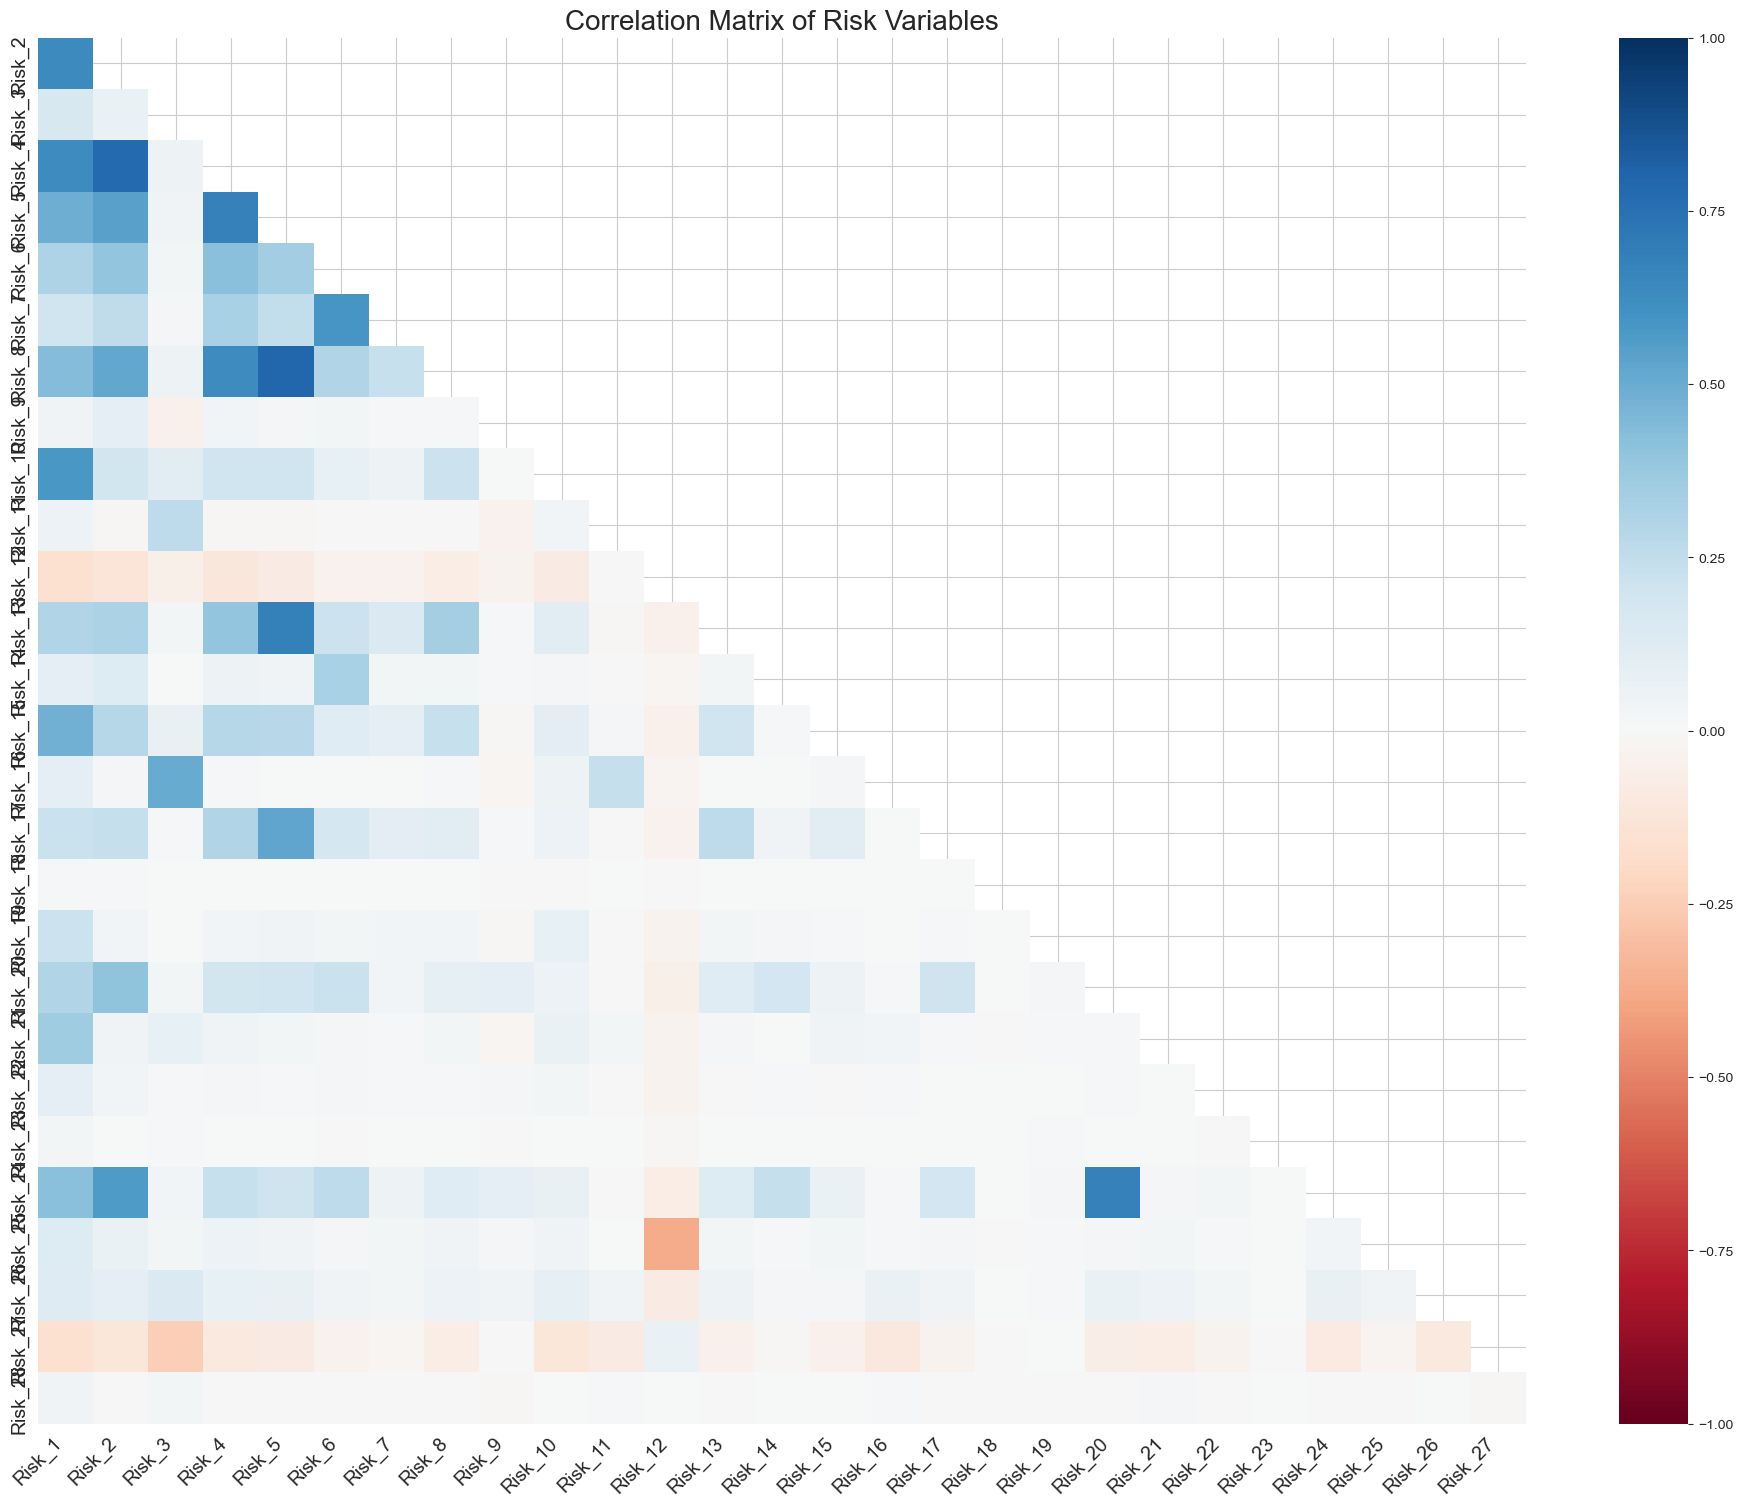

In [71]:
# Correlation
corr = df[risk_columns].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))[1:, :-1]
corr = corr.iloc[1:, :-1].copy()

fig, ax = plt.subplots(figsize=(24, 18))
sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, center=0, annot=False, 
            cmap='RdBu', cbar=True, linecolor='white', linewidths=0)

ax.tick_params(left=False, bottom=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
plt.title('Correlation Matrix of Risk Variables', fontsize=20)
plt.show()

In [80]:
train_data.shape

(5531451, 191)

In [82]:
# train_data.to_feather('train.ftr')

In [83]:
categorical_columns

['Balance_30',
 'Balance_38',
 'Delinquency_63',
 'Delinquency_64',
 'Delinquency_66',
 'Delinquency_68',
 'Delinquency_114',
 'Delinquency_116',
 'Delinquency_117',
 'Delinquency_120',
 'Delinquency_126']

In [84]:
for i in categorical_columns:
    print(i, train_data[i].nunique())

Balance_30 3
Balance_38 7
Delinquency_63 6
Delinquency_64 4
Delinquency_66 2
Delinquency_68 7
Delinquency_114 2
Delinquency_116 2
Delinquency_117 7
Delinquency_120 2
Delinquency_126 3


In [85]:
for i in categorical_columns:
    print(i, train_data[i].unique())

Balance_30 ['0.0', '2.0', '1.0', NaN]
Categories (3, object): ['0.0', '1.0', '2.0']
Balance_38 ['2.0', '1.0', '3.0', '5.0', '6.0', '7.0', '4.0', NaN]
Categories (7, object): ['1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0']
Delinquency_63 ['CR', 'CO', 'CL', 'XZ', 'XM', 'XL']
Categories (6, object): ['CL', 'CO', 'CR', 'XL', 'XM', 'XZ']
Delinquency_64 ['O', 'R', NaN, 'U', '-1']
Categories (4, object): ['-1', 'O', 'R', 'U']
Delinquency_66 [NaN, '1.0', '0.0']
Categories (2, object): ['0.0', '1.0']
Delinquency_68 ['6.0', '2.0', '3.0', NaN, '5.0', '4.0', '0.0', '1.0']
Categories (7, object): ['0.0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0']
Delinquency_114 ['1.0', '0.0', NaN]
Categories (2, object): ['0.0', '1.0']
Delinquency_116 ['0.0', NaN, '1.0']
Categories (2, object): ['0.0', '1.0']
Delinquency_117 ['4.0', '-1.0', '6.0', '2.0', '1.0', NaN, '3.0', '5.0']
Categories (7, object): ['-1.0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0']
Delinquency_120 ['0.0', '1.0', NaN]
Categories (2, object): 

In [89]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5531451 entries, 0 to 5531450
Columns: 191 entries, customer_ID to target
dtypes: category(11), datetime64[ns](1), float16(176), float64(1), int8(1), object(1)
memory usage: 2.0+ GB


In [90]:
categoric = [i for i in train_data.columns if train_data[i].dtype == 'category']

In [91]:
categoric

['Delinquency_63',
 'Delinquency_64',
 'Delinquency_66',
 'Delinquency_68',
 'Balance_30',
 'Balance_38',
 'Delinquency_114',
 'Delinquency_116',
 'Delinquency_117',
 'Delinquency_120',
 'Delinquency_126']

In [ ]:
['Delinquency_63',
 'Delinquency_64',
 'Delinquency_66',
 'Delinquency_68',
 'Balance_30',
 'Balance_38',
 'Delinquency_114',
 'Delinquency_116',
 'Delinquency_117',
 'Delinquency_120',
 'Delinquency_126']

In [92]:
categorical_columns

['Balance_30',
 'Balance_38',
 'Delinquency_63',
 'Delinquency_64',
 'Delinquency_66',
 'Delinquency_68',
 'Delinquency_114',
 'Delinquency_116',
 'Delinquency_117',
 'Delinquency_120',
 'Delinquency_126']

In [ ]:
categorical_columns = ["Balance_30", "Balance_38", "Delinquency_63", "Delinquency_64", "Delinquency_66", "Delinquency_68",
                       "Delinquency_114", "Delinquency_116", "Delinquency_117", "Delinquency_120", "Delinquency_126"]

In [93]:
numerical_columns

['Payment_2',
 'Delinquency_39',
 'Balance_1',
 'Balance_2',
 'Risk_1',
 'Spend_3',
 'Delinquency_41',
 'Balance_3',
 'Delinquency_42',
 'Delinquency_43',
 'Delinquency_44',
 'Balance_4',
 'Delinquency_45',
 'Balance_5',
 'Risk_2',
 'Delinquency_46',
 'Delinquency_47',
 'Delinquency_48',
 'Delinquency_49',
 'Balance_6',
 'Balance_7',
 'Balance_8',
 'Delinquency_50',
 'Delinquency_51',
 'Balance_9',
 'Risk_3',
 'Delinquency_52',
 'Payment_3',
 'Balance_10',
 'Delinquency_53',
 'Spend_5',
 'Balance_11',
 'Spend_6',
 'Delinquency_54',
 'Risk_4',
 'Spend_7',
 'Balance_12',
 'Spend_8',
 'Delinquency_55',
 'Delinquency_56',
 'Balance_13',
 'Risk_5',
 'Delinquency_58',
 'Spend_9',
 'Balance_14',
 'Delinquency_59',
 'Delinquency_60',
 'Delinquency_61',
 'Balance_15',
 'Spend_11',
 'Delinquency_62',
 'Delinquency_65',
 'Balance_16',
 'Balance_17',
 'Balance_18',
 'Balance_19',
 'Balance_20',
 'Spend_12',
 'Risk_6',
 'Spend_13',
 'Balance_21',
 'Delinquency_69',
 'Balance_22',
 'Delinquency_70',

In [94]:
train_data["customer_ID"].dtype

dtype('O')

In [95]:
train_data["Spend_2"].dtype

dtype('<M8[ns]')

In [97]:
[i for i in train_data.columns if train_data[i].dtype== '<M8[ns]']

['Spend_2']

In [98]:
[i for i in train_data.columns if train_data[i].dtype== 'O']

['customer_ID']

In [101]:
for i in numerical_columns:
    print(train_data[i].dtype)

float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16


In [102]:
train_data['target'].dtype

dtype('float64')

In [103]:
for i in numerical_columns:
    print(train_data[i].min(), train_data[i].max())

-0.459 1.01
0.0 5.39
-7.59 1.324
0.0 1.01
0.0 3.256
-0.627 5.484
0.0 8.99
0.0 1.625
-0.0004544 4.19
1e-07 10.11
0.0 5.633
0.0 19.8
0.0 1.61
0.0 144.2
0.0 1.01
-17.3 16.31
-0.02663 1.644
-0.00961 8.97
5e-07 45.84
-0.005177 1215.0
-2.652 1.253
0.0 1.02
-306.5 244.0
0.0 2.676
0.0 27.42
0.0 11.6
-0.007084 1.01
-1.52 2.428
-0.002958 4096.0
6e-08 7.902
0.0 206.9
0.0 1.971
0.0 1.01
-0.002007 1.01
0.0 1.01
-0.4702 3.95
6e-08 420.8
0.0 1.231
0.0 2.768
-0.01709 10.95
0.0 276.2
0.0 35.0
0.0 1.262
3e-07 2.84
-8.47 55.0
-0.1024 2.154
0.0 1.01
-0.00926 868.5
-10.01 65.06
-0.2 3.8
-0.002823 11.1
0.0 386.0
0.0 1.01
6e-08 1.01
6e-08 1.01
0.0 1.01
0.0 1.01
-0.404 175.4
0.0 14.445
0.0 1.01
0.0 288.2
0.0 13000.0
0.0 3.508
0.0 7.004
0.0 67.06
0.0 3.01
-0.3 5.31
6e-08 1.693
-0.04526 3.854
0.0 1.27
0.0 4.508
0.0 4.273
3e-07 15.13
0.0 46.6
0.0 450.0
0.0 10.23
-11.25 15.7
0.0 1499.0
0.0 16.02
0.0 18.0
0.0 38.0
3e-07 1.51
0.0 231.8
0.0 8.01
0.0 21.0
0.0 12.5
0.0 1.005
0.0 8.01
6e-08 3.008
0.0 4.05
-0.0918 1.01


In [104]:
numerical_columns

['Payment_2',
 'Delinquency_39',
 'Balance_1',
 'Balance_2',
 'Risk_1',
 'Spend_3',
 'Delinquency_41',
 'Balance_3',
 'Delinquency_42',
 'Delinquency_43',
 'Delinquency_44',
 'Balance_4',
 'Delinquency_45',
 'Balance_5',
 'Risk_2',
 'Delinquency_46',
 'Delinquency_47',
 'Delinquency_48',
 'Delinquency_49',
 'Balance_6',
 'Balance_7',
 'Balance_8',
 'Delinquency_50',
 'Delinquency_51',
 'Balance_9',
 'Risk_3',
 'Delinquency_52',
 'Payment_3',
 'Balance_10',
 'Delinquency_53',
 'Spend_5',
 'Balance_11',
 'Spend_6',
 'Delinquency_54',
 'Risk_4',
 'Spend_7',
 'Balance_12',
 'Spend_8',
 'Delinquency_55',
 'Delinquency_56',
 'Balance_13',
 'Risk_5',
 'Delinquency_58',
 'Spend_9',
 'Balance_14',
 'Delinquency_59',
 'Delinquency_60',
 'Delinquency_61',
 'Balance_15',
 'Spend_11',
 'Delinquency_62',
 'Delinquency_65',
 'Balance_16',
 'Balance_17',
 'Balance_18',
 'Balance_19',
 'Balance_20',
 'Spend_12',
 'Risk_6',
 'Spend_13',
 'Balance_21',
 'Delinquency_69',
 'Balance_22',
 'Delinquency_70',

In [106]:
len(train_data.select_dtypes(include='float16').columns.to_list())

176

In [107]:
len(numerical_columns)

176

In [115]:
train_data.head(1)

,customer_ID,Spend_2,Payment_2,Delinquency_39,Balance_1,Balance_2,Risk_1,Spend_3,Delinquency_41,Balance_3,...,Delinquency_137,Delinquency_138,Delinquency_139,Delinquency_140,Delinquency_141,Delinquency_142,Delinquency_143,Delinquency_144,Delinquency_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938477,0.001734,0.008728,1.006836,0.009224,0.124023,0.008774,0.004707,...,NaN,NaN,0.002426,0.003706,0.003819,NaN,0.000569,0.00061,0.002674,0.0


In [117]:
df = train_data.groupby('customer_ID').tail(1).set_index('customer_ID')
df = df.drop('Spend_2', axis=1)
df.target.value_counts()

target
0.0    27976
1.0    10047
Name: count, dtype: int64

In [118]:
train_data.shape

(5531451, 191)

In [119]:
df.shape

(458913, 189)